In [1]:
%load_ext autoreload
%autoreload 2
import importlib
import call_tree
import main
import networkx as nx
import math
import copy

(df, function_names, ltacm, rtacm, G) = main.init()

In [2]:
df.keys()

Index(['traceId', 'fusionGroup', 'source', 'currentFunction', 'billedDuration',
       'maxMemoryUsed', 'isRootInvocation', 'memory', 'startTimestamp',
       'endTimestamp', 'internalDuration', 'calls'],
      dtype='object')

In [3]:

last_setup = list(main.cm.keys())[-1]
last_df = df[df['fusionGroup'] == last_setup]
(last_function_names, last_ltacm, last_rtacm, last_G) = main.get_from_df(last_df)

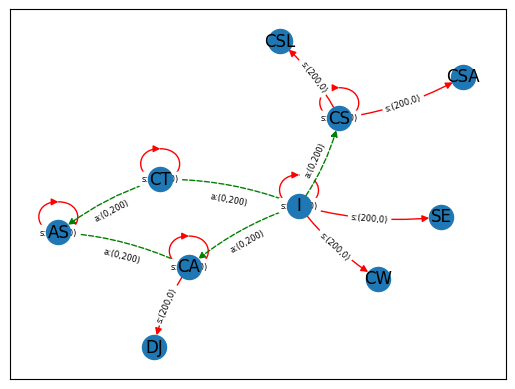

In [4]:
import matplotlib.pyplot as plt
import drawing_helper as dh

def draw_graph(G: nx.MultiDiGraph):
    # https://stackoverflow.com/questions/22785849/drawing-multiple-edges-between-two-nodes-with-networkx
    # pos = nx.spring_layout(G, seed=1, k=20/math.sqrt(G.order()), scale=None)
    pos = nx.nx_pydot.graphviz_layout(G)
    fig, ax = plt.subplots()

    # draw nodes
    arc_rad = 0.1
    node_size = 300
    nx.draw_networkx_nodes(G, pos, node_size=node_size)
    nx.draw_networkx_labels(G, pos, ax=ax)

    # draw edges
    #curved_edges = [edge for edge in G.edges if edge in G.reverse().edges]
    #straight_edges = list(set(G.edges()) - set(curved_edges))
    #nx.draw_networkx_edges(G, pos, ax=ax, edgelist=straight_edges)
    

    sync_edges = list(filter(lambda e: e[2] == "sync" and (len(G.edges[e]["local"]) + len(G.edges[e]["remote"]) > 0), G.edges))
    #nx.draw_networkx_edges(G, pos, ax=ax, edgelist=sync_edges, connectionstyle=f'arc3, rad = {arc_rad}', edge_color="red", node_size=node_size)
    mostly_local_sync_edges = list(filter(lambda e: G.edges[e]["local"] >= G.edges[e]["remote"], sync_edges))
    nx.draw_networkx_edges(G, pos, ax=ax, edgelist=mostly_local_sync_edges, connectionstyle=f'arc3, rad = {arc_rad}', edge_color="red", node_size=node_size, style="solid")
    mostly_remote_sync_edges = list(filter(lambda e: e not in mostly_local_sync_edges, sync_edges))
    nx.draw_networkx_edges(G, pos, ax=ax, edgelist=mostly_remote_sync_edges, connectionstyle=f'arc3, rad = {arc_rad}', edge_color="red", node_size=node_size, style="dashed")


    async_edges = list(filter(lambda e: e[2] == "async" and (len(G.edges[e]["local"]) + len(G.edges[e]["remote"]) > 0), G.edges))
    #nx.draw_networkx_edges(G, pos, ax=ax, edgelist=async_edges, connectionstyle=f'arc3, rad = {arc_rad * -1}', edge_color="green", node_size=node_size)
    mostly_local_async_edges = list(filter(lambda e: G.edges[e]["local"] >= G.edges[e]["remote"], async_edges))
    nx.draw_networkx_edges(G, pos, ax=ax, edgelist=mostly_local_async_edges, connectionstyle=f'arc3, rad = {arc_rad}', edge_color="green", node_size=node_size, style="solid")
    mostly_remote_async_edges = list(filter(lambda e: e not in mostly_local_async_edges, async_edges))
    nx.draw_networkx_edges(G, pos, ax=ax, edgelist=mostly_remote_async_edges, connectionstyle=f'arc3, rad = {arc_rad}', edge_color="green", node_size=node_size, style="dashed")

    # Draw Edge Labels
    sync_edge_labels = {edge: f's:({len(G.edges[edge[0], edge[1], "sync"]["local"])},{len(G.edges[edge[0], edge[1], "sync"]["remote"])})' for edge in sync_edges}
    async_edge_labels = {edge: f'a:({len(G.edges[edge[0], edge[1], "async"]["local"])},{len(G.edges[edge[0], edge[1], "async"]["remote"])})' for edge in async_edges}

    dh.draw_networkx_edge_labels(G, pos, ax=ax, edge_labels=sync_edge_labels,rotate=True,font_size=6,rad = arc_rad)
    dh.draw_networkx_edge_labels(G, pos, ax=ax, edge_labels=async_edge_labels,rotate=True,font_size=6,rad = arc_rad * -1)
    #fig.savefig("3.png", bbox_inches='tight',pad_inches=0)

draw_graph(last_G)

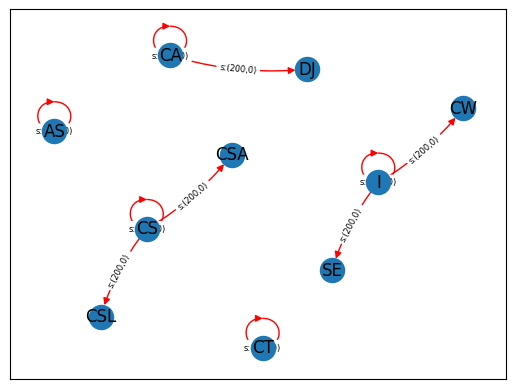

In [5]:
def get_sync_trees(G: nx.MultiDiGraph):
    G = copy.deepcopy(G)
    edgelist = list(G.edges)
    for (u,v,d) in edgelist:
        if d == "async":
            G.remove_edge(u,v,d)
    return G

sync_G = get_sync_trees(last_G)
draw_graph(sync_G)

1. Get ACG for every past fusion setup
2. Delete edges that happen very infrequently (or only very old)
3. Find Synchronous Subtrees and their historical state

In [10]:
def get_unconnected_subtrees(G):
    """
    Returns a list of all subtrees from nodes that are the root of an invocation
    """
    graphs = []

    # Root nodes have a sync call to themselves
    root_nodes = [set([u]) for (u,v,d) in G.edges if u == v]
    #print(f'{root_nodes=}')
    #print([f'{e=}' for e in root_nodes])

    descendants = [nx.descendants(G, next(iter(n))) for n in root_nodes]
    #print(f'{descendants=}')

    subgraph_nodes = []
    for idx, e in enumerate(descendants):
        all_E = e | root_nodes[idx]
        subgraph_nodes.append(all_E)
    #print(f'{subgraph_nodes=}')



    return [nx.subgraph(G, nodes) for nodes in subgraph_nodes]

#[draw_graph(G) for G in get_unconnected_subtrees(sync_G)]

In [7]:
all_G = [call_tree.get_call_graph(df[df["fusionGroup"] == name]) for name in df["fusionGroup"].unique()]
all_sync_G = [get_sync_trees(G) for G in all_G]